### Neural network LSTM prediction/classification using Keras and Google Colab

 LSTM (Long short term memory) is a variant of RNN (Recurring Neural network) that remembers past data using a memory cell feature. One of its use case is to predict time series datasets and langauge.
 
 In this project, we use a RNN(LSTM) model to predict if the room is occupied in the next min.

 We introduce data lead/lag, to predict if room is occupied in the next time instance.

Skills: keras, scikitlearn, pandas, numpy, google colab, neural networks

dataset: http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

---
Load the data.

### 1) Loading the datasets and python libraries  
  
For this project we utilised Google's colab cloud GPUs as it takes a long time to train LSTM models.  
Using GPUs, instead of running it locally on a laptop, helps to save processing time.  
  
This section shows how u can use google colab:  
1) load your data files into cloud  
2) link the data files to the colab notebook to run

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding, LSTM
from keras.layers import Dropout
from keras.layers import Dense
import pickle as pk

In [45]:
# upload the csv files (using google drive links):

link1 = 'https://drive.google.com/open?id=1kTmIOBdGoHZUMexPpBsNO2yP8qBdGrJl'
link2 = 'https://drive.google.com/open?id=1DnoQf1iA8er0bzRhfEZO-Sp7BxBoUJyA'
link3 = 'https://drive.google.com/open?id=10KJW3GkFwJugJpRzGRdhX0qwXa6L1Raz'
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
dtest1 = pd.read_csv('Filename.csv')

fluff, id = link2.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
dtest2 = pd.read_csv('Filename.csv')

fluff, id = link3.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
dtrain = pd.read_csv('Filename.csv')


print(dtest1.shape) # datatest.csv
print(dtest2.shape) # datatest2.csv
print(dtrain.shape) # datatraining.csv
dtrain.columns

(2665, 7)
(9752, 7)
(8143, 7)


Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

### 2) Data preparation  
  
As the dataset is a time series, there is a need to sort the data set by date to get the order correct.  
Next, we train-test split the data. As a check, I would print out the result dataframe shape.

In [46]:
#sort by time, x_train, y_train, x_test, y_test
# we need to sort by data to organise the time series

dtrain.sort_values("date", ascending= True)
x_train = dtrain[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
y_train = dtrain['Occupancy']

dtest1.sort_values("date", ascending= True)
x_test = dtest1[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
y_test = dtest1['Occupancy']

dtest2.sort_values("date", ascending= True)
x_test2 = dtest2[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
y_test2 = dtest2['Occupancy']

print("Before timestep:")
print()
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_test2 shape:', x_test2.shape)
print()
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_test2 shape:', y_test2.shape)


Before timestep:

x_train shape: (8143, 5)
x_test shape: (2665, 5)
x_test2 shape: (9752, 5)

y_train shape: (8143,)
y_test shape: (2665,)
y_test2 shape: (9752,)


In [47]:
dtrain.sort_values("date", ascending= True)
dtrain

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


### 3) Data wangling, introduce prediction in a classification model  
To allow the model to predict, we shifted the x and y of the model to allow Variables (in T) to aline with target class (T+1).  
Given that the data is order most recent day last, we deleted the last row of x, and then delete first row of y.

In [48]:
# shift: delete x, last day (last row), delete y, first day (first row)
# but shifting this way, we map historical value with predicted future

x_train = x_train.drop(x_train.index[-1])
x_test = x_test.drop(x_test.index[-1])
x_test2 = x_test2.drop(x_test2.index[-1])

y_train = y_train.drop(y_train.index[0])
y_test = y_test.drop(y_test.index[0])
y_test2 = y_test2.drop(y_test2.index[0])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_test2 shape:', x_test2.shape)
print()
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_test2 shape:', y_test2.shape)

x_train shape: (8142, 5)
x_test shape: (2664, 5)
x_test2 shape: (9751, 5)

y_train shape: (8142,)
y_test shape: (2664,)
y_test2 shape: (9751,)


### 4) Standard scaling of data, and introducing 'time step' into the data array  
  
Given that all the data points are numerical and continuous. We use standard scaler to standardised it.  
To introduce 'time step' dimension to the data, we use the reshape function. 

In [ ]:
# Standard Scale numerial feature data
numerical_data = x_train.select_dtypes(include=['float64', 'int64']).copy()
data_tmp = numerical_data.values #returns a numpy array
std_scaler = preprocessing.StandardScaler()
data_tmp = std_scaler.fit_transform(x_train)
x_train = pd.DataFrame(data_tmp, columns=numerical_data.columns)

x_test = std_scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=numerical_data.columns)

x_test2 = std_scaler.transform(x_test2)
x_test2 = pd.DataFrame(x_test2, columns=numerical_data.columns)

x_col_name = x_train.columns
features = len(x_col_name)


In [51]:
#converting 2D data into 3D for LSTM, LSTM(data rows,timestep, features)
# add time step

x_train =np.array(x_train)
x_test = np.array(x_test)
x_test2 = np.array(x_test2)

x_train = np.reshape(x_train, (x_train.shape[0], -1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], -1, x_test.shape[1]))
x_test2 = np.reshape(x_test2, (x_test2.shape[0], -1, x_test2.shape[1]))
print()
print("After timestep:")
print()
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_test2 shape:', x_test2.shape)
print()
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_test2 shape:', y_test2.shape)


After timestep:

x_train shape: (8142, 1, 5)
x_test shape: (2664, 1, 5)
x_test2 shape: (9751, 1, 5)

y_train shape: (8142,)
y_test shape: (2664,)
y_test2 shape: (9751,)


### 5) Train the LSTM model 

Key features: dropout() to avoid overfitting the model  

In this model, we use train_x: train the model, test: to validate the model, test2: to test the results.
  
Parameters to tune:  
1) Epoch  
2) Batch size  
3) activation function  
4) network layers  
5) nodes  

In [54]:
sample= len(x_train)
features = len(x_col_name)
timesteps = 1

# train LSTM model, x_train, y_train ~ x_test, y_test
network = models.Sequential() #implied more than 1 sample
network.add(LSTM(100, input_shape=(timesteps,features)))
network.add(Dropout(0.2))
network.add(Dense(32, activation='sigmoid'))
network.add(Dense(1, activation='sigmoid'))


# Observe the use loss function in the codes below
network.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Observe the setting of shuffle to True
# Play around the epochs, batch_size to see the effect 
# (Try to achieve <0.001 loss)

history= network.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=22, batch_size=100, verbose =1, shuffle = False)

## JIMMY: You should use x_test2 and y_test2 for evaluation. (-5 marks)
test_loss, test_acc = network.evaluate(x_test2, y_test2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)




Train on 8142 samples, validate on 2664 samples
Epoch 1/22





8142/8142 [==============================] - 10s 1ms/step - loss: 0.5451 - acc: 0.8070 - val_loss: 0.4543 - val_acc: 0.8525
Epoch 2/22
8142/8142 [==============================] - 1s 71us/step - loss: 0.2934 - acc: 0.9122 - val_loss: 0.2309 - val_acc: 0.9426
Epoch 3/22
8142/8142 [==============================] - 1s 66us/step - loss: 0.1685 - acc: 0.9611 - val_loss: 0.1613 - val_acc: 0.9576
Epoch 4/22
8142/8142 [==============================] - 1s 65us/step - loss: 0.1233 - acc: 0.9713 - val_loss: 0.1321 - val_acc: 0.9655
Epoch 5/22
8142/8142 [==============================] - 1s 70us/step - loss: 0.0995 - acc: 0.9808 - val_loss: 0.1152 - val_acc: 0.9726
Epoch 6/22
8142/8142 [==============================] - 1s 68us/step - loss: 0.0839 - acc: 0.9851 - val_loss: 0.1045 - val_acc: 0.9764
Epoch 7/22
8142/8142 [==============================] - 1s 78us/step - loss: 0.0734 - acc: 0.9870 - val_loss: 0.0975 - val_acc: 0.9767

---
Summary of the model created.

In [53]:
network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 45,665
Trainable params: 45,665
Non-trainable params: 0
_________________________________________________________________


---
Train the model.

---
Plot the training curve.

### 6) Model evaluation  
  
Given that the accuracy performed very well, 98%+ accuraccy for both validation and test data, we can say that the LSTM model performed well in production.  
In terms of model accuracy and loss plots, we can see that it is fairly consistent, with both following a consistent sloped curve. The flattening of both curve can be seen around 7 epoch, suggesting that the model is optimised from that epoch onwards. 

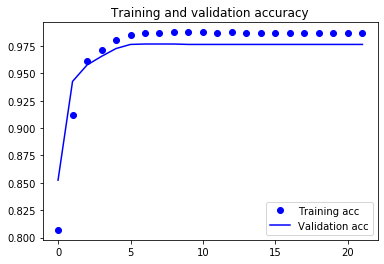

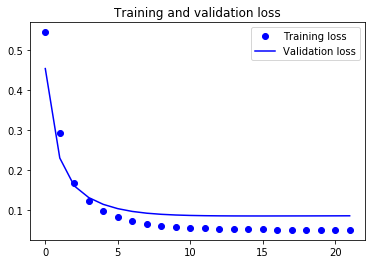

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [56]:
#testing model against testset 2

test_loss, test_acc = network.evaluate(x_test, y_test)
print()
print("Model validation against testset 1:")
print()
print('test loss:', test_loss)
print('test accuracy:', test_acc)
print()
print()

## JIMMY: This evaluation is correct (+5 marks back)
test_loss, test_acc = network.evaluate(x_test2, y_test2)
print()
print("Model validation against testset 2:")
print()
print('test2 loss:', test_loss)
print('test2 accuracy:', test_acc)

2664/2664 [==============================] - 0s 75us/step

Model validation against testset 1:

test loss: 0.08662065491779475
test accuracy: 0.9763513513513513


9751/9751 [==============================] - 1s 67us/step

Model validation against testset 2:

test2 loss: 0.045121963765407606
test2 accuracy: 0.9906676238579036


In [ ]:
# save the model
pk.dump(history, open('model.pkl', 'wb'))
# save the scaler
pk.dump(std_scaler, open('scaler.pkl', 'wb'))